In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import scipy.fftpack as fft

from tqdm import tqdm
import pickle

from swimAD2 import swimAD2 as ad2       
import time
import dwfconstants as dwfc

ad2.disconnect()            
zoroku = ad2.connect(0)      #彼は老人
# alice = ad2.connect(1)      #彼女はアンドロイド

In [6]:
def sampling_h(time):
    # Priority on oscilloscope hertz
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        return size,hertz

def sampling_s(time):
    # Priority on data size
    size = 8192
    hertz = size/time
    if hertz <= 100e6:
        return size,hertz
    else: 
        hertz = 100e6
        return size,hertz

# Test inidividually 

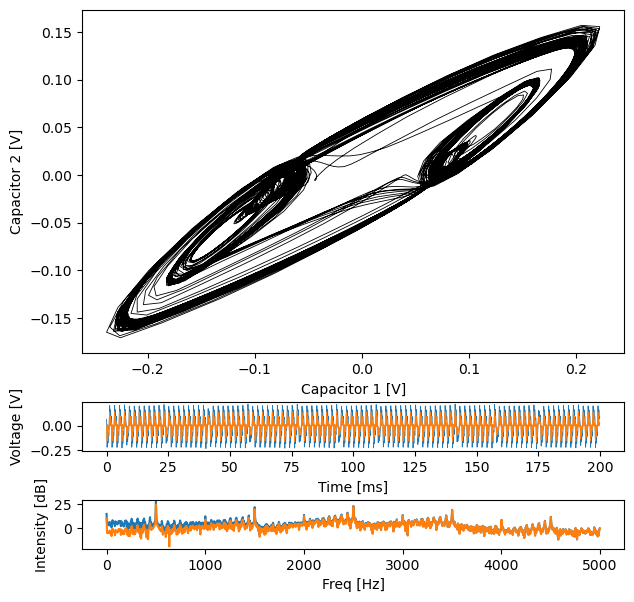

In [152]:
size,rate = sampling_s(0.2)
rng = 3

ad2.config_oscilloscope(zoroku,
        range0=rng,
        range1=rng,
        sample_rate = rate,
        sample_size= size,
        )

ad2.config_wavegen(zoroku, 
        frequency=500,
        amplitude=0.0785,
        # signal_shape=dwfc.funcSine
        )

ad2.start_wavegen(zoroku,channel=0)
time.sleep(0.1)

t0,ch1,ch2 = ad2.measure_oscilloscope(zoroku)

ad2.stop_wavegen(zoroku,channel=0)
ad2.reset_wavegen(zoroku,channel=0)

data = [t0,ch1,ch2]

# handle = open("chua_troubleshoot.pkl", 'wb')
# pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
# handle.close()
# No syncing involved
fig,axs = plt.subplots(3,1,figsize=(7,7)
                       ,sharey="row",height_ratios=[7,1,1])
fig.subplots_adjust(wspace=0.05,hspace=0.33)

fourier = [np.abs(fft.fft(sol)) for sol in [ch1,ch2]] 
fourier = [10*np.log10(fou) for fou in fourier] 
# fourier = [fou/np.max(fou) for fou in fourier] # Normalise wrt maximum.
    
tau = t0[1]-t0[0] # time interval

freq = fft.fftfreq(len(ch1), tau)

axs[0].plot(ch1,ch2
            ,linewidth=0.6,color="k"
            )

for var in [ch1,ch2]:
    axs[1].plot(t0*1000, var,linewidth=0.6)

for j in range(2): 
    axs[2].plot(freq[freq>=0][:1000], fourier[j][freq>=0][:1000])

axs[0].set_ylabel("Capacitor 2 [V]")
axs[0].set_xlabel("Capacitor 1 [V]")

axs[1].set_ylabel("Voltage [V]")
axs[1].set_xlabel("Time [ms]")

axs[2].set_ylabel("Intensity [dB]")
axs[2].set_xlabel("Freq [Hz]")

plt.show()
plt.close("all")

# Variable frequencies

In [158]:
def make_fig(t0,ch1,ch2,f,amp):
    fig,axs = plt.subplots(3,1,figsize=(7,7)
                       ,sharey="row",height_ratios=[7,1,1])
    fig.subplots_adjust(wspace=0.05,hspace=0.33)

    fourier = [np.abs(fft.fft(sol)) for sol in [ch1,ch2]] 
    fourier = [10*np.log10(fou) for fou in fourier] 
    # fourier = [fou/np.max(fou) for fou in fourier] # Normalise wrt maximum.
        
    tau = t0[1]-t0[0] # time interval

    freq = fft.fftfreq(len(ch1), tau)

    axs[0].plot(ch1,ch2
                ,linewidth=0.6,color="k"
                )

    for var in [ch1,ch2]:
        axs[1].plot(t0*1000, var,linewidth=0.6)

    for j in range(2): 
        axs[2].plot(freq[freq>=0][:1000], fourier[j][freq>=0][:1000])

    axs[0].set_ylabel("Capacitor 2 [V]")
    axs[0].set_xlabel("Capacitor 1 [V]")

    axs[1].set_ylabel("Voltage [V]")
    axs[1].set_xlabel("Time [ms]")

    axs[2].set_ylabel("Intensity [dB]")
    axs[2].set_xlabel("Freq [Hz]")

    plt.savefig(f"collected_data/Plotted_{f}Hz-{amp}V.png")
    plt.close("all")

# Variable amplitudes

In [170]:
freq = 500
amp = np.round(np.linspace(.001,1.,200),decimals=3) # High freq

data = {}
for i,F in tqdm(enumerate(amp)):
    duration = 20/f if 1/f<5 else 5
    size,rate = sampling_s(duration)
    rng = 3

    ad2.config_oscilloscope(zoroku,
            range0=rng,
            range1=rng,
            sample_rate = rate,
            sample_size= size,
            )

    ad2.config_wavegen(zoroku, 
            frequency=freq,
            amplitude=F,
            # signal_shape=dwfc.funcSine
            )

    ad2.start_wavegen(zoroku,channel=0)
    time.sleep(0.1)

    data[F] = ad2.measure_oscilloscope(zoroku)

    ad2.stop_wavegen(zoroku,channel=0)
    ad2.reset_wavegen(zoroku,channel=0)
    if i%10==0:
        make_fig(*data[F],f=freq,amp=F)

        
handle = open("collected_data/chua_varamp.pkl", 'wb')
pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

200it [00:30,  6.53it/s]


In [167]:
freq = np.round(np.linspace(100,1000,200),decimals=3) # High freq
amp = 0.078

data = {}
for i,f in tqdm(enumerate(freq)):
    duration = 20/f if 1/f<5 else 5
    size,rate = sampling_s(duration)
    rng = 3

    ad2.config_oscilloscope(zoroku,
            range0=rng,
            range1=rng,
            sample_rate = rate,
            sample_size= size,
            )

    ad2.config_wavegen(zoroku, 
            frequency=f,
            amplitude=amp,
            # signal_shape=dwfc.funcSine
            )

    ad2.start_wavegen(zoroku,channel=0)
    time.sleep(0.1)

    data[f] = ad2.measure_oscilloscope(zoroku)

    ad2.stop_wavegen(zoroku,channel=0)
    ad2.reset_wavegen(zoroku,channel=0)
    if i%10==0:
        make_fig(*data[f],f=f,amp=amp)

        
handle = open("collected_data/chua_varfreq.pkl", 'wb')
pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

200it [00:36,  5.43it/s]


# Load specific measurements

In [166]:
handle = open("collected_data/chua_varfreq.pkl", 'rb')
data=pickle.load(handle)
handle.close()

data.keys()

# make_fig()

dict_keys([100.0, 109.091, 118.182, 127.273, 136.364, 145.455, 154.545, 163.636, 172.727, 181.818, 190.909, 200.0, 209.091, 218.182, 227.273, 236.364, 245.455, 254.545, 263.636, 272.727, 281.818, 290.909, 300.0, 309.091, 318.182, 327.273, 336.364, 345.455, 354.545, 363.636, 372.727, 381.818, 390.909, 400.0, 409.091, 418.182, 427.273, 436.364, 445.455, 454.545, 463.636, 472.727, 481.818, 490.909, 500.0, 509.091, 518.182, 527.273, 536.364, 545.455, 554.545, 563.636, 572.727, 581.818, 590.909, 600.0, 609.091, 618.182, 627.273, 636.364, 645.455, 654.545, 663.636, 672.727, 681.818, 690.909, 700.0, 709.091, 718.182, 727.273, 736.364, 745.455, 754.545, 763.636, 772.727, 781.818, 790.909, 800.0, 809.091, 818.182, 827.273, 836.364, 845.455, 854.545, 863.636, 872.727, 881.818, 890.909, 900.0, 909.091, 918.182, 927.273, 936.364, 945.455, 954.545, 963.636, 972.727, 981.818, 990.909, 1000.0])